In [17]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  The Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing a dataset of images with the grok codec and store it into HDF5.

Data can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5
"""

'\nBenchmark for compressing a dataset of images with the grok codec and store it into HDF5.\n\nData can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5\n'

In [18]:
import h5py
import blosc2
import blosc2_grok
import numpy as np
import hdf5plugin
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import io
from time import time

In [19]:
# Params for the frame iterator
verbose = True
all_frames = False
meas = {}  # dictionary for storing the measurements

In [20]:
# Define the compression and decompression parameters for Blosc2.
# Disable the filters and the splitmode, because these don't work with grok.
cparams = {
    'codec': 160,
    'nthreads': 1,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}

In [21]:
# Compression params for identifying the codec. In the future, one should be able to
# specify the grok plugin (and its parameters) here.
b2params = hdf5plugin.Blosc2()

In [22]:
# Register grok codec locally
blosc2.register_codec('grok', 160)

In [23]:
# Open the dataset
f = h5py.File('/Users/faltet/Downloads/lung_raw_2000-2100.h5', 'r')
dset = f['/data']
if all_frames:
    nframes = dset.shape[0]
else:
    nframes = 1
print(f"Compressing dataset of {dset.shape} images ...")

Compressing dataset of (100, 1024, 2048) images ...


In [24]:
# Compress the dataset with different compression ratios
quality_mode = "rates"
print(f"Quality mode: {quality_mode}")
ssims = []
cratios = []
times = []
range_vals = list(range(1, 11))
range_vals_str = "range(1, 11)"
for cratio in range_vals:
    if verbose:
        print(f"Compressing with cratio={cratio}x ...")
    # Set the parameters that will be used by grok
    kwargs = {
        'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
        'num_threads': 1,  # this does not have any effect (grok should work in multithreading mode)
        'quality_mode': quality_mode,
        'quality_layers': np.array([cratio], dtype=np.float64)
    }
    blosc2_grok.set_params_defaults(**kwargs)

    # Open the output file
    fout = h5py.File(f'/Users/faltet/Downloads/lung_jpeg2k_2000-2100-{cratio}x.h5', 'w')
    chunks = (1,) + dset.shape[1:]
    dset_out = fout.create_dataset('/data', shape=dset.shape, dtype=dset.dtype, chunks=chunks, **b2params)
    
    # Iterate over the frames
    iter_frames = tqdm(range(nframes)) if verbose else range(nframes)
    for i in iter_frames:
        im = dset[i:i+1, ...]
        # Transform the numpy array to a blosc2 array. This is where compression happens.
        t0 = time()
        b2im = blosc2.asarray(im, chunks=im.shape, blocks=im.shape, cparams=cparams)
        if i == 0:
            times.append(time() - t0)

        # Write to disk
        dset_out.id.write_direct_chunk((i, 0, 0), b2im.schunk.to_cframe())
        if i == 0:
            cratios.append(b2im.schunk.cratio)
            # Compare with the original image
            im2 = b2im[:]
            ssim_ = ssim(im[0], im2[0], data_range=im.max() - im.min())
            ssims.append(ssim_)
    if verbose:
        print(f"SSIM: {ssim_}")
    fout.close()
meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times}


Quality mode: rates
Compressing with cratio=1x ...


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


SSIM: 1.0
Compressing with cratio=2x ...


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


SSIM: 0.9999916447775955
Compressing with cratio=3x ...


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


SSIM: 0.9997366286504493
Compressing with cratio=4x ...


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


SSIM: 0.998480645565877
Compressing with cratio=5x ...


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


SSIM: 0.9953252792409132
Compressing with cratio=6x ...


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


SSIM: 0.99017780867514
Compressing with cratio=7x ...


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


SSIM: 0.9834849765953608
Compressing with cratio=8x ...


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


SSIM: 0.9760613417147925
Compressing with cratio=9x ...


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


SSIM: 0.9691640482889801
Compressing with cratio=10x ...


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

SSIM: 0.9620092727516698


Text(0, 0.5, 'SSIM index')

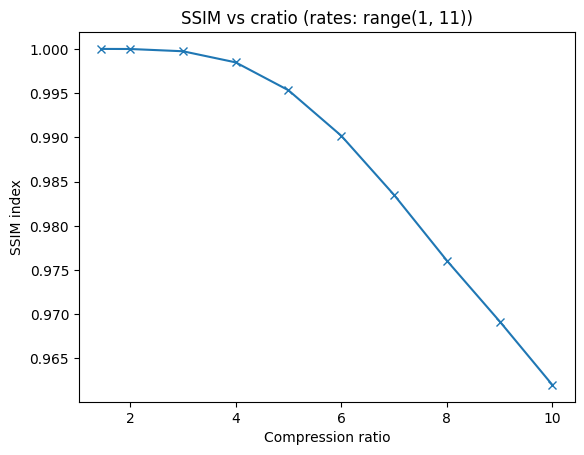

In [25]:
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], 'x-')
plt.title(f'SSIM vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')


Text(0, 0.5, 'SSIM index')

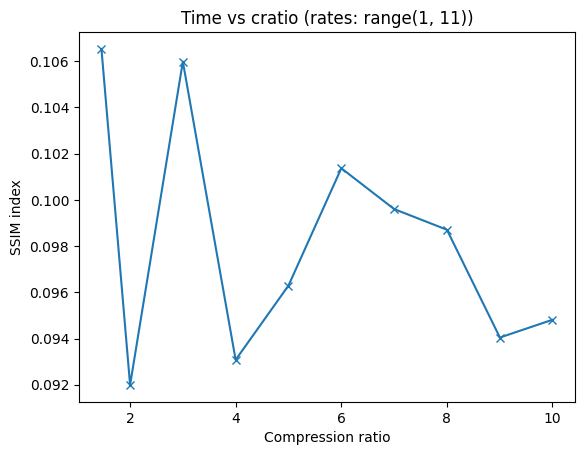

In [26]:
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['times'], 'x-')
plt.title(f'Time vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Time (s)')


In [27]:
# Compress the dataset with different SNR values
quality_mode = "dB"
print(f"Quality mode: {quality_mode}")
ssims = []
cratios = []
times = []
range_vals = list(range(90, 45, -5))
range_vals_str = "range(90, 45, -5)"
for quality in range_vals:
    if verbose:
        print(f"Compressing with quality={quality}dB ...")
    # Set the parameters that will be used by grok
    kwargs = {
        'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
        'num_threads': 1,  # this does not have any effect (grok should work in multithreading mode)
        'quality_mode': quality_mode,
        'quality_layers': np.array([quality], dtype=np.float64)
    }
    blosc2_grok.set_params_defaults(**kwargs)

    # Open the output file
    fout = h5py.File(f'/Users/faltet/Downloads/lung_jpeg2k_2000-2100-{quality}dB.h5', 'w')
    chunks = (1,) + dset.shape[1:]
    dset_out = fout.create_dataset('/data', shape=dset.shape, dtype=dset.dtype, chunks=chunks, **b2params)

    # Iterate over the frames
    iter_frames = tqdm(range(nframes)) if verbose else range(nframes)
    for i in iter_frames:
        im = dset[i:i + 1, ...]
        # Transform the numpy array to a blosc2 array. This is where compression happens.
        t0 = time()
        b2im = blosc2.asarray(im, chunks=im.shape, blocks=im.shape, cparams=cparams)
        if i == 0:
            times.append(time() - t0)

        # Write to disk
        dset_out.id.write_direct_chunk((i, 0, 0), b2im.schunk.to_cframe())
        if i == 0:
            cratios.append(b2im.schunk.cratio)
            # Compare with the original image
            im2 = b2im[:]
            ssim_ = ssim(im[0], im2[0], data_range=im.max() - im.min())
            ssims.append(ssim_)
    if verbose:
        print(f"SSIM: {ssim_}")
    fout.close()
meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times}


Quality mode: dB
Compressing with quality=90dB ...


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


SSIM: 0.9999939901345466
Compressing with quality=85dB ...


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


SSIM: 0.999982697492922
Compressing with quality=80dB ...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


SSIM: 0.9999469551201942
Compressing with quality=75dB ...


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


SSIM: 0.9998340566379452
Compressing with quality=70dB ...


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


SSIM: 0.9994730420152326
Compressing with quality=65dB ...


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


SSIM: 0.9982993273786245
Compressing with quality=60dB ...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


SSIM: 0.9946490823271262
Compressing with quality=55dB ...


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


SSIM: 0.9825723555175582
Compressing with quality=50dB ...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

SSIM: 0.944130406248733


Text(0, 0.5, 'SSIM index')

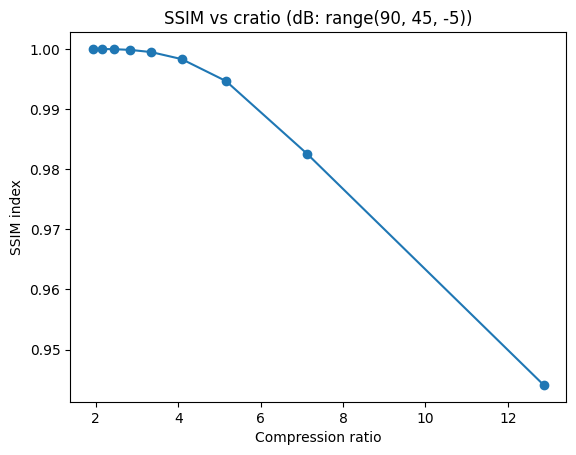

In [28]:
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], 'o-')
plt.title(f'SSIM vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')


Text(0, 0.5, 'Time (s)')

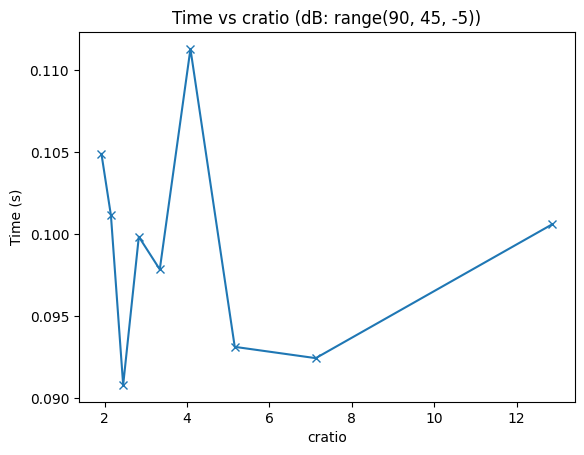

In [29]:
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['times'], 'x-')
plt.title(f'Time vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('cratio')
plt.ylabel('Time (s)')

In [30]:
# Compress the dataset with pillow
quality_mode = "dB-OpenJPEG"
print(f"Quality mode: {quality_mode}")
ssims = []
cratios = []
times = []
range_vals = list(range(90, 45, -5))
range_vals_str = "range(90, 45, -5)"
for quality in range_vals:
    if verbose:
        print(f"Compressing with quality={quality}dB ...")
    # Set the parameters that will be used by grok
    kwargs = {
        'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
        'num_threads': 1,  # this does not have any effect (grok should work in multithreading mode)
        'quality_mode': quality_mode,
        'quality_layers': np.array([quality], dtype=np.float64)
    }
    blosc2_grok.set_params_defaults(**kwargs)

    # Open the output file
    fout = h5py.File(f'/Users/faltet/Downloads/lung_jpeg2k_2000-2100-{quality}dB-pillow.h5', 'w')
    chunks = (1,) + dset.shape[1:]
    dset_out = fout.create_dataset('/data', shape=dset.shape, dtype=dset.dtype, chunks=chunks, **b2params)

    # Iterate over the frames
    iter_frames = tqdm(range(nframes)) if verbose else range(nframes)
    for i in iter_frames:
        im = dset[i, ...]
        # Use pillow for compressing
        j2kim = Image.fromarray(im)
        t0 = time()
        j2kbio = io.BytesIO()
        j2kim.save(j2kbio, format='JPEG2000', quality_mode="dB", quality_layers=[quality])
        if i == 0:
            times.append(time() - t0)

        # Write to disk
        im_bytes = j2kbio.getvalue()
        dset_out.id.write_direct_chunk((i, 0, 0), im_bytes)
        if i == 0:
            cratio = im.nbytes / len(im_bytes)
            cratios.append(cratio)
            # Compare with the original image
            im2 = Image.open(io.BytesIO(im_bytes))
            im2 = np.array(im2)
            ssim_ = ssim(im[0], im2[0], data_range=im.max() - im.min())
            ssims.append(ssim_)
    if verbose:
        print(f"SSIM: {ssim_}")
    fout.close()
meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times}


Quality mode: dB-OpenJPEG
Compressing with quality=90dB ...


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


SSIM: 0.9999928046532017
Compressing with quality=85dB ...


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


SSIM: 0.9999765856893845
Compressing with quality=80dB ...


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


SSIM: 0.9999367918182738
Compressing with quality=75dB ...


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


SSIM: 0.999808289791511
Compressing with quality=70dB ...


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


SSIM: 0.9993516656737023
Compressing with quality=65dB ...


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


SSIM: 0.9978738065066692
Compressing with quality=60dB ...


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SSIM: 0.9929454558446105
Compressing with quality=55dB ...


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


SSIM: 0.9759631964871213
Compressing with quality=50dB ...


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

SSIM: 0.928961126118552


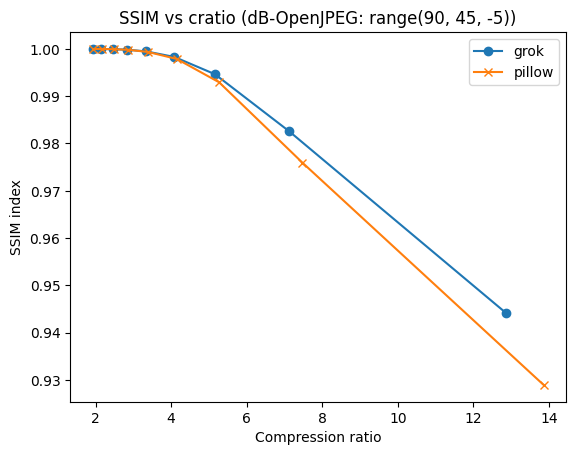

In [31]:
plt.plot(meas["dB"]['cratios'], meas["dB"]['ssims'], 'o-', label="grok")
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], 'x-', label="pillow")
plt.title(f'SSIM vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

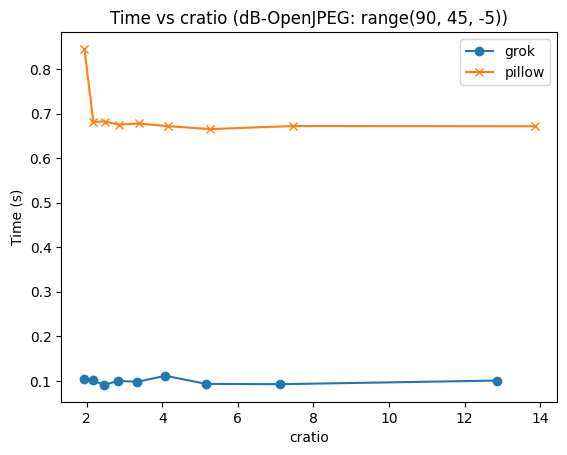

In [32]:
plt.plot(meas["dB"]['cratios'], meas["dB"]['times'], 'o-', label="grok")
plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['times'], 'x-', label="pillow")
plt.title(f'Time vs cratio ({quality_mode}: {range_vals_str})')
plt.xlabel('cratio')
plt.ylabel('Time (s)')
plt.legend()